# Capstone Project: Starbucks

# 1. Question

*Is there an algorithem that allows us to predict if a customer (given a certain offer) will complete this offer? This way can only send offers to cusomers who will complete it (the others don't need it).*

# 2. Wrangle

## 2.1 Gather Data

In [106]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sb
#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2.2 Assess

*First let's create some functions which can be used through the whole notebook for creating some charts*

In [107]:
#create function for pie carts
def pie_chart(table, column):
    value = table[column].value_counts()

    plt.pie(value, labels = value.index, autopct='%.2f', startangle = 90, counterclock = False);
    plt.axis('square')
    plt.title('Piechart with percentage shown for {}'.format(column))
    

In [108]:
#create function for Histogram charts 
def hist_chart(table, column):
    plt.hist(data= table, x = column);
    plt.xlabel(column)
    plt.ylabel('count')
    plt.title('Distribution for {}'.format(column))

*Now let's have a look at how the data looks*

In [109]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


**Channels should not contain multiple things --> Clean it by showing each channel in a different column**

**it might be beneficial to create dummy variable out of offer_type for further investigation**

In [110]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


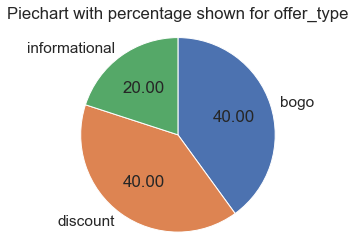

In [111]:
pie_chart(portfolio, 'offer_type')

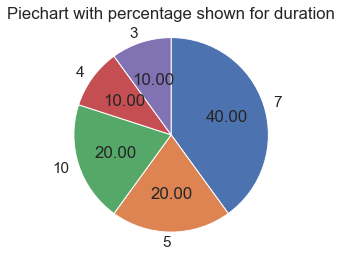

In [112]:
pie_chart(portfolio, 'duration')

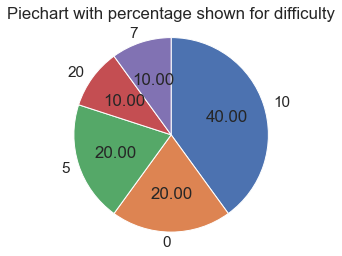

In [113]:
pie_chart(portfolio, 'difficulty')

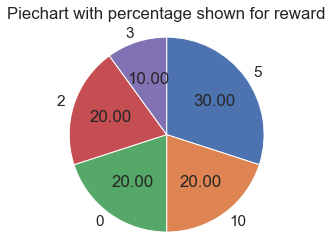

In [114]:
pie_chart(portfolio, 'reward')

In [115]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**The income and gender columns have a lot of NaN. This might be problem later on**

In [116]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


*Let's have a closer look at age and gender*

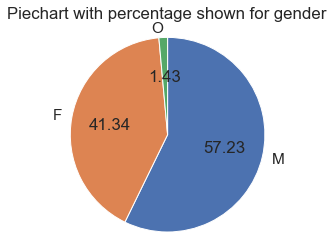

In [117]:
pie_chart(profile, 'gender')

*More males seem to be in the data*

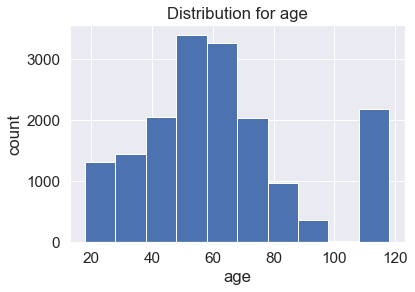

In [118]:
hist_chart(profile, 'age')

In [119]:
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: age, Length: 85, dtype: int64

**Age 118 seems to be a lot in the data (with 2175 data points) this seems to be the age, if the customer didn't give a age at all**

*Let's have a closer look at those with age 118*

In [120]:
profile_sub = profile[profile['age'] == 118]

In [121]:
profile_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            0 non-null      object 
 1   age               2175 non-null   int64  
 2   id                2175 non-null   object 
 3   became_member_on  2175 non-null   int64  
 4   income            0 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


**So those with age 118 have no info about gender and income at all --> because there is no other info in here (except for when they became a member) it might be beneficial to delete these lines, because those are the line with the NaN in gender and income**

In [122]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [123]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [124]:
#let's create a sub df where transaction is not part 
trans_sub = transcript[transcript['event']!='transaction']

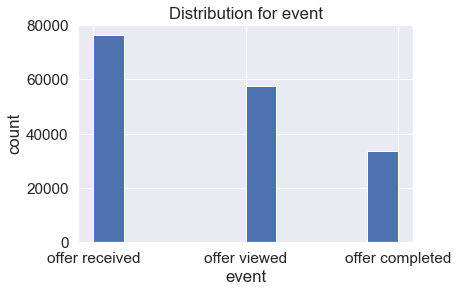

In [125]:
hist_chart(trans_sub, 'event')

*not all offers that where received where even viewed and even less (although offers are completed without beeing even seen) are completed*

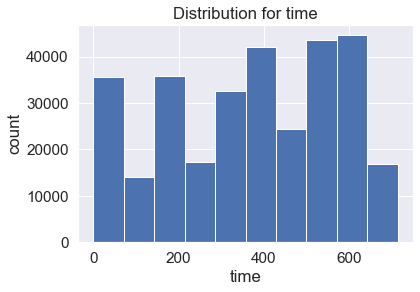

In [126]:
hist_chart(transcript, 'time')

In [127]:
transcript[transcript['person'] == '76ddbd6576844afe811f1a3c0fbb5bec']

,person,event,value,time
12639,76ddbd6576844afe811f1a3c0fbb5bec,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
34050,76ddbd6576844afe811f1a3c0fbb5bec,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},60
38218,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 2.87},78
42025,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 0.52},96
47579,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 0.19},126
49500,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 0.9},138
50455,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 1.43},144
69322,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 112.6},168
69323,76ddbd6576844afe811f1a3c0fbb5bec,offer completed,"{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}",168
103833,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 2.12},288


**value holds different kind of information (somtetimes offer id and if it is a transaction than it hold the amount spent) --> needs to be in different columns**

*offer id is written differently in value (offer id and offer_id)

**it might be beneficial to create dummy variables out of event for further investigation and coding**

## 2.3 Clean the data

**What has to be cleaned:**
1. portfolio:
    - channels holds more than one info
    - offer_type column holds different things

2. profile:
    - missing data in gender and income 
    - age 118 is not the real age of the customer --> placeholder

3. transcript:
    - value holds more than one info
    - offer id is written differntly in value
    - event column holds differnt things

**Problem: Channel in table portfolio holds more than one info**

In [128]:
#create list with names for dummies
list_ins = list(pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).groupby(level= 0).sum().columns)

In [129]:
#create dummies for channels
portfolio[list_ins] = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).groupby(level= 0).sum()

**Check**

In [130]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


*channels is now no longer necessary*

In [131]:
portfolio = portfolio.drop(['channels'], axis = 1)

**check again**

In [132]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


**Problem: offer_type holds differnt info --> would be easier to create algorithem if it where a dummy**

In [133]:
#create dummys 
portfolio[list(pd.get_dummies(portfolio['offer_type']).groupby(level= 0).sum().columns)] =pd.get_dummies(portfolio['offer_type'])

**Check**

In [134]:
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


*offer_type column no longer needed*

In [135]:
portfolio = portfolio.drop(['offer_type'], axis = 1)

**Check again**

In [136]:
portfolio.head()

,reward,difficulty,duration,id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


**Problem: Age 118 is not the real age of customer --> placeholder**

**Problem: missing data in gender and income**

In [137]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


*As shown above those with age 118 have nonthine in gender and income (all the missing values in those columns are customers with age 118). So there is no info about those customers exept of the became_member_on date for those customers. Because there is no info gained (in regard of demographic info) with those customers I'll drop those lines*

In [138]:
#Drop lines with cusomers aged 118
profile = profile[profile['age'] != 118]

**Check**

In [139]:
profile[profile['age'] == 118]

,gender,age,id,became_member_on,income


**Problem: column value holds more than one info**

In [140]:
#unpack tuples to dataframe
transcript = transcript.join(transcript.value.apply(lambda x: pd.Series(x)))

**Check**

In [141]:
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


**Problem: offer id is written differntly in value**

In [142]:
#fill offer_id with offer id if nan (offer id hold offer received and viewed)
transcript.offer_id.fillna(transcript['offer id'], inplace=True)

In [143]:
#del column offer id and value
transcript = transcript.drop(columns = ['value', 'offer id'])

In [144]:
pd.set_option('display.max_colwidth', None)

**Check**

In [145]:
transcript[transcript['person'] == '24f56b5e1849462093931b164eb803b5']

,person,event,time,amount,offer_id,reward
49497,24f56b5e1849462093931b164eb803b5,transaction,138,21.39,NaN,NaN
51345,24f56b5e1849462093931b164eb803b5,transaction,150,14.12,NaN,NaN
98955,24f56b5e1849462093931b164eb803b5,transaction,264,16.92,NaN,NaN
123504,24f56b5e1849462093931b164eb803b5,offer received,336,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
163333,24f56b5e1849462093931b164eb803b5,offer received,408,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
177250,24f56b5e1849462093931b164eb803b5,offer viewed,426,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
214243,24f56b5e1849462093931b164eb803b5,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
221893,24f56b5e1849462093931b164eb803b5,offer viewed,510,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
306526,24f56b5e1849462093931b164eb803b5,transaction,714,22.64,NaN,NaN
306527,24f56b5e1849462093931b164eb803b5,offer completed,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0


**Problem: event column holds differnt things**

In [146]:
#create dummys 
transcript[list(pd.get_dummies(transcript['event']).groupby(level= 0).sum().columns)] =pd.get_dummies(transcript['event'])

In [147]:
#delete event column
transcript = transcript.drop(columns = ['event'])

**Check**

In [148]:
transcript.head()

,person,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


**fill reward, offer_id and amount with 0 if NaN**

In [149]:
transcript.reward.fillna(0, inplace=True)
transcript.amount.fillna(0, inplace = True)
transcript.offer_id.fillna(0, inplace = True)

**Check**

In [150]:
transcript[transcript['person'] == '24f56b5e1849462093931b164eb803b5']

,person,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
49497,24f56b5e1849462093931b164eb803b5,138,21.39,0,0.0,0,0,0,1
51345,24f56b5e1849462093931b164eb803b5,150,14.12,0,0.0,0,0,0,1
98955,24f56b5e1849462093931b164eb803b5,264,16.92,0,0.0,0,0,0,1
123504,24f56b5e1849462093931b164eb803b5,336,0.00,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0,1,0,0
163333,24f56b5e1849462093931b164eb803b5,408,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0,0
177250,24f56b5e1849462093931b164eb803b5,426,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,0,1,0
214243,24f56b5e1849462093931b164eb803b5,504,0.00,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0,0
221893,24f56b5e1849462093931b164eb803b5,510,0.00,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,0,1,0
306526,24f56b5e1849462093931b164eb803b5,714,22.64,0,0.0,0,0,0,1
306527,24f56b5e1849462093931b164eb803b5,714,0.00,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0,0,0


# 3 Explore

In [151]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   person           306534 non-null  object 
 1   time             306534 non-null  int64  
 2   amount           306534 non-null  float64
 3   offer_id         306534 non-null  object 
 4   reward           306534 non-null  float64
 5   offer completed  306534 non-null  uint8  
 6   offer received   306534 non-null  uint8  
 7   offer viewed     306534 non-null  uint8  
 8   transaction      306534 non-null  uint8  
dtypes: float64(2), int64(1), object(2), uint8(4)
memory usage: 12.9+ MB


In [152]:
df = transcript.merge(profile, how = 'left', left_on='person', right_on = 'id')

In [153]:
df = df.merge(portfolio, how = 'left', left_on = 'offer_id', right_on = 'id' )

In [154]:
#drop id and id_y 
df = df.drop(columns = ['id_x', 'id_y'])

In [155]:
df.head()

,person,time,amount,offer_id,reward_x,offer completed,offer received,offer viewed,transaction,gender,...,reward_y,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0,F,...,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0,NaN,...,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0,M,...,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0,0,NaN,...,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0,0,NaN,...,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [156]:
#rename reward_x to reward_received and reward_y to reward

df= df.rename(columns={'reward_x': 'reward_received', 'reward_y':'reward'})

In [157]:
df.head()

,person,time,amount,offer_id,reward_received,offer completed,offer received,offer viewed,transaction,gender,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0,F,...,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0,NaN,...,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0,M,...,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0,0,NaN,...,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0,0,NaN,...,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306534 non-null  object 
 1   time              306534 non-null  int64  
 2   amount            306534 non-null  float64
 3   offer_id          306534 non-null  object 
 4   reward_received   306534 non-null  float64
 5   offer completed   306534 non-null  uint8  
 6   offer received    306534 non-null  uint8  
 7   offer viewed      306534 non-null  uint8  
 8   transaction       306534 non-null  uint8  
 9   gender            272762 non-null  object 
 10  age               272762 non-null  float64
 11  became_member_on  272762 non-null  float64
 12  income            272762 non-null  float64
 13  reward            167581 non-null  float64
 14  difficulty        167581 non-null  float64
 15  duration          167581 non-null  float64
 16  email             16

### look at offer_completed and compare to received

In [159]:
df_sub = df[df['offer completed'] == 1]

In [160]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33579 entries, 12658 to 306527
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            33579 non-null  object 
 1   time              33579 non-null  int64  
 2   amount            33579 non-null  float64
 3   offer_id          33579 non-null  object 
 4   reward_received   33579 non-null  float64
 5   offer completed   33579 non-null  uint8  
 6   offer received    33579 non-null  uint8  
 7   offer viewed      33579 non-null  uint8  
 8   transaction       33579 non-null  uint8  
 9   gender            32444 non-null  object 
 10  age               32444 non-null  float64
 11  became_member_on  32444 non-null  float64
 12  income            32444 non-null  float64
 13  reward            33579 non-null  float64
 14  difficulty        33579 non-null  float64
 15  duration          33579 non-null  float64
 16  email             33579 non-null  f

*there are a few wihtout info about age and gender* 

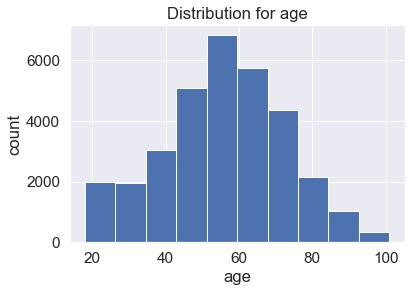

In [161]:
hist_chart(df_sub, 'age')

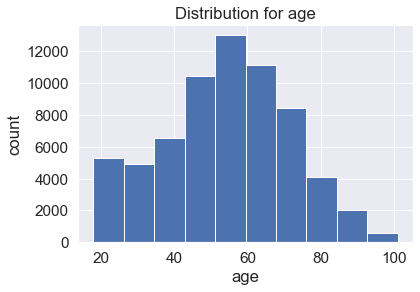

In [162]:
#look in comparision to offer received
df_rec = df[df['offer received'] == 1]
hist_chart(df_rec, 'age')

*It seems people around the age of 50 (+/-10 years) are more likely to complete an offer given whereas people around 20-40 aren't completing offers as much.*

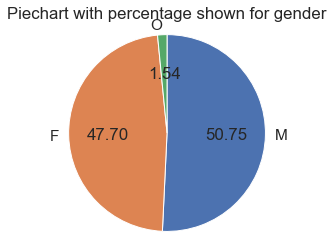

In [163]:
pie_chart(df_sub, 'gender')

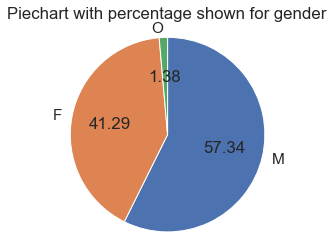

In [164]:
pie_chart(df_rec, 'gender')

*It seems women (and in a smaller basis Others) in general are more likely to complete an offer then men.*

**So in general we can point out that the age and the gender are to be concidered when sending out an offer**

### look at offers viewed

In [165]:
df_viewed = df[df['offer viewed'] == 1]

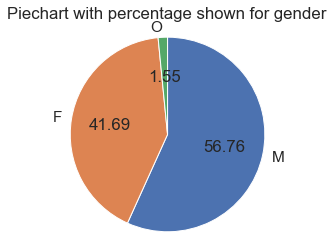

In [166]:
pie_chart(df_viewed, 'gender')

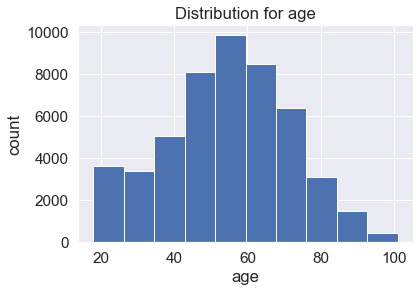

In [167]:
hist_chart(df_viewed, 'age')

**so age and gender might be import for completing an offer, but it seems looking at the offer is distributed the same way as receiving one**

### Lets have a look at the transactions

In [168]:
df_trans = df[df['transaction'] == 1]

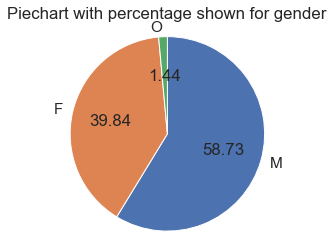

In [169]:
pie_chart(df_trans, 'gender')

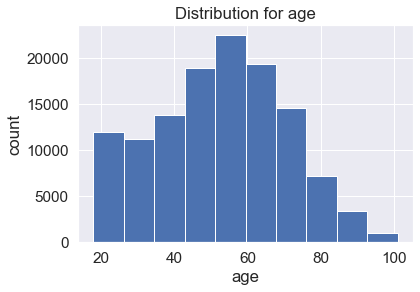

In [170]:
hist_chart(df_trans, 'age')

**it seems slightly more men than women are more likly to do some transactions**

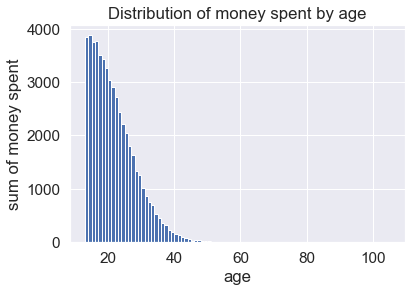

In [171]:
bins = np.arange(int(df.age.min())-5, int(df.age.max())+5, 1)
plt.hist(data= df, x = 'amount', bins = bins);
plt.title('Distribution of money spent by age')
plt.xlabel('age')
plt.ylabel('sum of money spent');

**a lot of young peple between the age of 18 to 30 seem to spent a lot of money.**

In [172]:
df_sub.head()

,person,time,amount,offer_id,reward_received,offer completed,offer received,offer viewed,transaction,gender,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,0.0,2906b810c7d4411798c6938adc9daaa5,2.0,1,0,0,0,M,...,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
12672,fe97aa22dd3e48c8b143116a8403dd52,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0,0,0,F,...,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
12679,629fc02d56414d91bca360decdfa9288,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,0,M,...,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
12692,676506bad68e4161b9bbaffeb039626b,0,0.0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,1,0,0,0,M,...,10.0,10.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,1,0,0,0,M,...,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


### Look at duration

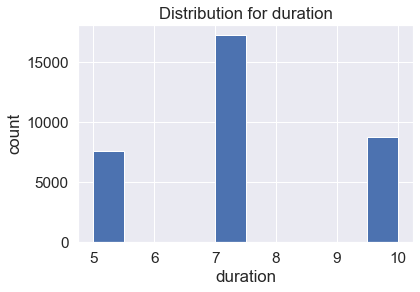

In [173]:
hist_chart(df_sub, 'duration')

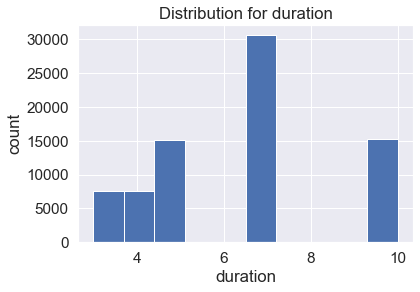

In [174]:
hist_chart(df_rec, 'duration')

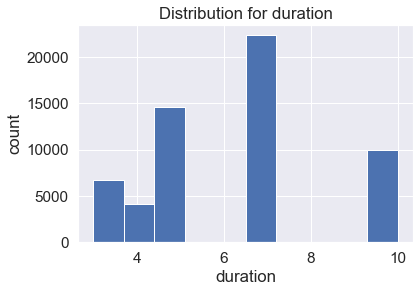

In [175]:
hist_chart(df_viewed, 'duration')

**the offers with 3/4 days don't seem to work. 7/10 Days seem to be a good approach for an offer to be sent out.** 

### Look at income

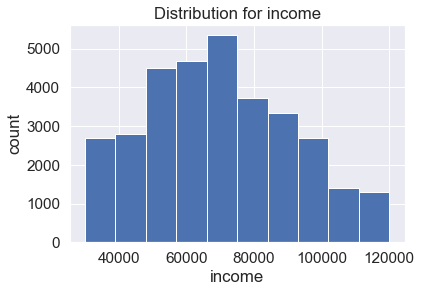

In [176]:
#completed offer
hist_chart(df_sub, 'income')

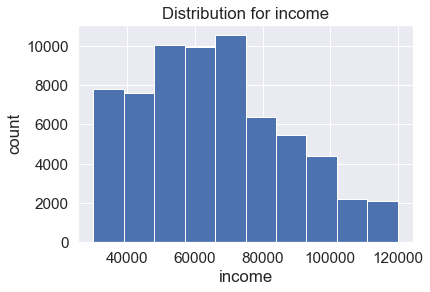

In [177]:
#received offer
hist_chart(df_rec, 'income')

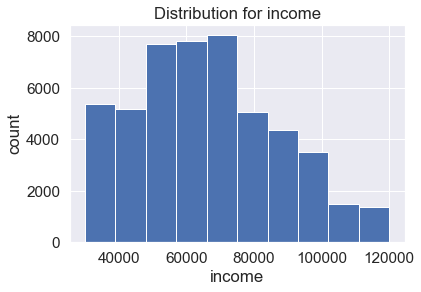

In [178]:
#viewed offer
hist_chart(df_viewed, 'income')

*it might be a little bit more likely to complete an offer around an income of 7000 and people with an income under 5000 seem not to complete offers that often but it is only small*

### Look at channels

In [179]:
#percentage of email
df_sub.email.sum()/df_viewed.email.sum()*100

58.17063663923776

In [180]:
#percentage of mobile
df_sub.mobile.sum()/df_viewed.mobile.sum()*100

54.77280156914024

In [181]:
#percentage of social
df_sub.social.sum()/df_viewed.social.sum()*100

51.11074620563466

In [182]:
#percentage of web
df_sub.web.sum()/df_viewed.web.sum()*100

67.44054871170073

**the web seems to be a good channel to promote something as it has the highest rate to succeed**

### Look on offers

In [183]:
df.head()

,person,time,amount,offer_id,reward_received,offer completed,offer received,offer viewed,transaction,gender,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0,F,...,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0,NaN,...,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0,M,...,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0,0,NaN,...,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0,0,NaN,...,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [184]:
#percentage on bogo offer completed
df_sub.bogo.sum()/df_viewed.bogo.sum()*100

61.570199221973354

In [185]:
#percentage on discount offer completed
df_sub.discount.sum()/df_viewed.discount.sum()*100

83.5159710888319

In [186]:
#percentage on informational offer completed
df_sub.informational.sum()/df_viewed.informational.sum()*100

0.0

**offer with discount are working far better than bogo.**

# 4. Conclustion of Analysis

*After cleaning the data and looking at it from different angles, it became apperent that the age and gender are import for completing an offer. On the other hand younger people tend to spent much more money on Starbucks without actually completing the offers. So it seems we should take the age and gender into consideration of sending out offers. For younger people we might have to think of differnt kind of offers.*

*Also intresting is the duration for an offer. It seems we should get rid of the 3/4 days offers, as they don't seem to work at all. Best is to use the 7/10 days offers.*

*Regarding the income it has a small infuluence on weather someone completes an offer or not, but it might not be that influencial for our later model.*

*The Channels are influencial on wether a person completes an offer or not. Web and email seem to have the best chances on completing an offer if it was viewed.*

*The kind of offer is important as well. It seems that a discount is working far better than the offer.*

**So the next step would be to implement an algorithem which helps to send out offers. The algorithem should send out the best offers to customers so that they are more likely to do an transaction afterwards.**

# 5. Algorithem for offers

In [187]:
#sort df by person and time
df = df.sort_values(['person', 'time']).reset_index(drop=True)

In [188]:
df.head()

,person,time,amount,offer_id,reward_received,offer completed,offer received,offer viewed,transaction,gender,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,0,1,0,0,M,...,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0009655768c64bdeb2e877511632db8f,192,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0,1,0,M,...,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0009655768c64bdeb2e877511632db8f,228,22.16,0,0.0,0,0,0,1,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,336,0.00,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0,0,M,...,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0009655768c64bdeb2e877511632db8f,372,0.00,3f207df678b143eea3cee63160fa8bed,0.0,0,0,1,0,M,...,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


*So the interesting thing would be if an offer was completed which means the offer worked and the customer spend the requiered money.*

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306534 non-null  object 
 1   time              306534 non-null  int64  
 2   amount            306534 non-null  float64
 3   offer_id          306534 non-null  object 
 4   reward_received   306534 non-null  float64
 5   offer completed   306534 non-null  uint8  
 6   offer received    306534 non-null  uint8  
 7   offer viewed      306534 non-null  uint8  
 8   transaction       306534 non-null  uint8  
 9   gender            272762 non-null  object 
 10  age               272762 non-null  float64
 11  became_member_on  272762 non-null  float64
 12  income            272762 non-null  float64
 13  reward            167581 non-null  float64
 14  difficulty        167581 non-null  float64
 15  duration          167581 non-null  float64
 16  email             16

In [190]:
# for Y we need the event in one column again
df['event'] = np.where(df['offer received']==1, 0, np.where(df['offer viewed']==1, 1, np.where(df['transaction']==1, 2, 3)))

In [191]:
df.head(10)

,person,time,amount,offer_id,reward_received,offer completed,offer received,offer viewed,transaction,gender,...,difficulty,duration,email,mobile,social,web,bogo,discount,informational,event
0,0009655768c64bdeb2e877511632db8f,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,0,1,0,0,M,...,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0
1,0009655768c64bdeb2e877511632db8f,192,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0,1,0,M,...,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1
2,0009655768c64bdeb2e877511632db8f,228,22.16,0,0.0,0,0,0,1,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,0009655768c64bdeb2e877511632db8f,336,0.00,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0,0,M,...,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
4,0009655768c64bdeb2e877511632db8f,372,0.00,3f207df678b143eea3cee63160fa8bed,0.0,0,0,1,0,M,...,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1
5,0009655768c64bdeb2e877511632db8f,408,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,1,0,0,M,...,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
6,0009655768c64bdeb2e877511632db8f,414,8.57,0,0.0,0,0,0,1,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
7,0009655768c64bdeb2e877511632db8f,414,0.00,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,0,M,...,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,3
8,0009655768c64bdeb2e877511632db8f,456,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,0,1,0,M,...,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1
9,0009655768c64bdeb2e877511632db8f,504,0.00,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0,0,M,...,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0


*for the model we need to rewrite gender: M:0, F:1, O:2*

In [192]:
df.gender.replace( ['M', 'F', 'O'], [0,1,2], inplace=True)

In [193]:
df.head()

,person,time,amount,offer_id,reward_received,offer completed,offer received,offer viewed,transaction,gender,...,difficulty,duration,email,mobile,social,web,bogo,discount,informational,event
0,0009655768c64bdeb2e877511632db8f,168,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,0,1,0,0,0.0,...,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0
1,0009655768c64bdeb2e877511632db8f,192,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0,0,0,1,0,0.0,...,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1
2,0009655768c64bdeb2e877511632db8f,228,22.16,0,0.0,0,0,0,1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,0009655768c64bdeb2e877511632db8f,336,0.00,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0,0,0.0,...,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
4,0009655768c64bdeb2e877511632db8f,372,0.00,3f207df678b143eea3cee63160fa8bed,0.0,0,0,1,0,0.0,...,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1


for the model we need to replace NaN with 0 

In [194]:
df.fillna(0, inplace = True)

In [195]:
#create test data
X = df[['gender', 'age', 'income', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']]

In [196]:
Y = df['event']

In [197]:
X

,gender,age,income,email,mobile,social,web,bogo,discount,informational
0,0.0,33.0,72000.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,33.0,72000.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.0,33.0,72000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,33.0,72000.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,33.0,72000.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
306529,1.0,45.0,62000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306530,1.0,45.0,62000.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
306531,1.0,45.0,62000.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
306532,1.0,45.0,62000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
Y

0         0
1         1
2         2
3         0
4         1
         ..
306529    2
306530    3
306531    1
306532    2
306533    2
Name: event, Length: 306534, dtype: int32

In [199]:
#split data in train and test
#use random_state=42 so the test does not vary (and also because it is the answer to everything)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)

In [200]:
#Built Model (Random Forest)
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [201]:
#predict
yhat = model.predict(X_test)

In [202]:
# evaluate predictions
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)

Accuracy: 0.584


*Accuracy score is not really high, maybe there is a way to improve the model*

In [203]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0,
            warm_start=False)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_jobs=1, random_state=0)

In [204]:
#predicta
y_2 = model.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, y_2)
print('Accuracy: %.3f' % acc)

Accuracy: 0.703


*Accuracy score is much better now.*

# 6. Conclusion of Algorithem

*So After improving the accuracy score we now look at the confusion matrix to determine if our model is sufficient enough.*

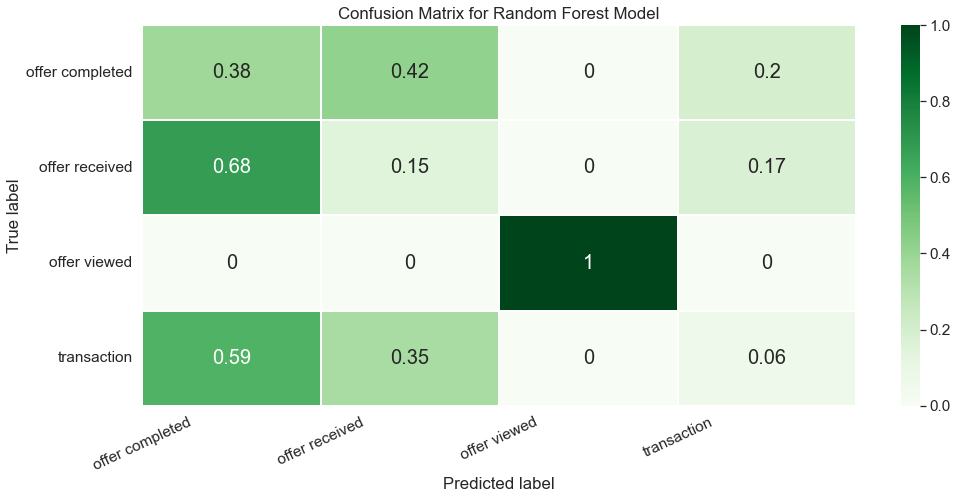

In [205]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, yhat)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sb.set(font_scale=1.4)
sb.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['offer completed', 'offer received', 'offer viewed', 'transaction']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model (First Model)')
plt.show()

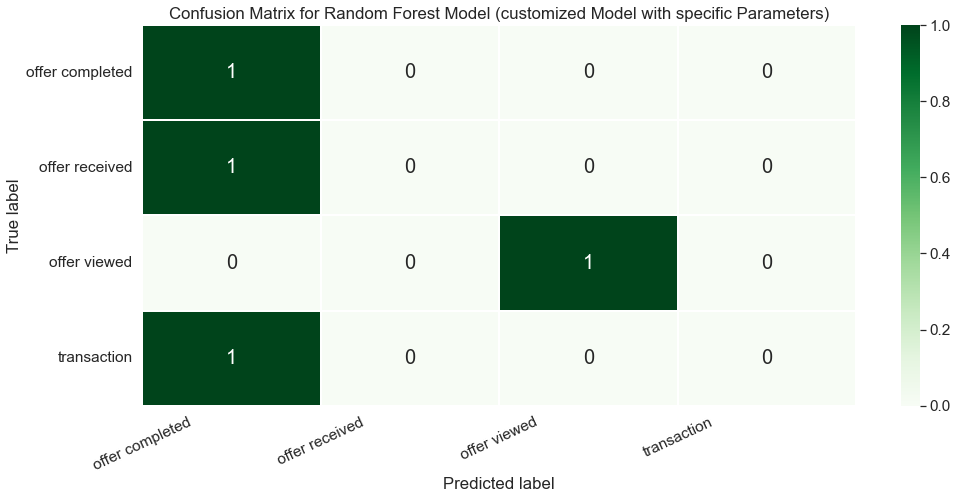

In [207]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_2)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sb.set(font_scale=1.4)
sb.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['offer completed', 'offer received', 'offer viewed', 'transaction']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model (customized Model with specific Parameters)')
plt.show()

*So the 2nd Models performs much better in regards of offer completed (which is our main goal).*


*So the model (the 2nd Model with the cusomized Parameters) seems to work for offer completed and offer viewed, but not all for offer received and transaction (this is not really surprising, because we changed the data for transaction and filled all the info with 0 for email,...).We wanted the offer completed to be correct because this means there was at least 1 transaction (otherwise the cusomer would not have the offer completed), so this seems to be a good starting point.*